In [35]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#BTC-USD

##7:2:1


In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/BTC-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [37]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [38]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

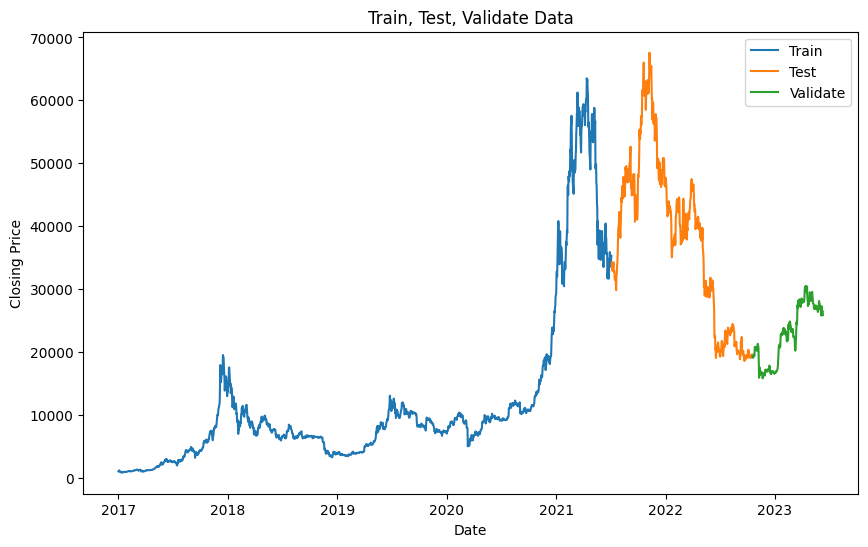

In [39]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [40]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [41]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [42]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

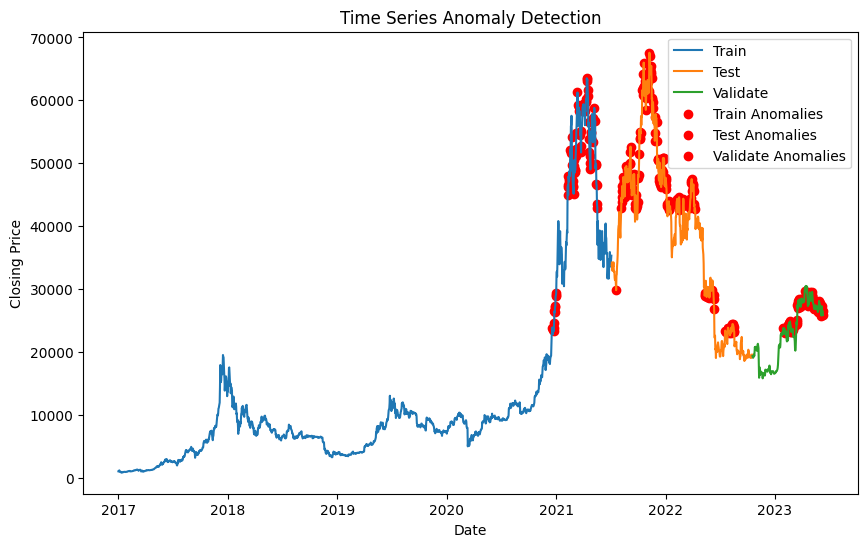

In [43]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

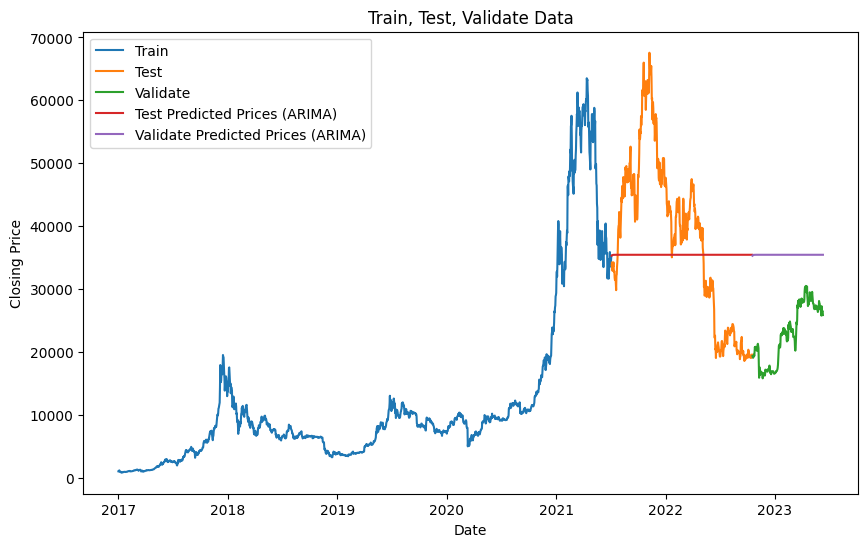

In [44]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [45]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 99.99985581474604
MAE: 22777.765002294895
RMSE: 23231.941309116813
Testing:
MAPE: 99.99994658750616
MAE: 37929.38826466999
RMSE: 40109.39347909248


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26619.278, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26629.632, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26623.493, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26624.529, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26628.773, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26617.325, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26617.260, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=26617.943, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26621.317, Time=1.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26619.345, Time=1.41 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=26616.407, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=26623.821, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=26615.749, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=26620.448, Time=0.76 sec
 ARIMA(2,1,2)(0,0,0

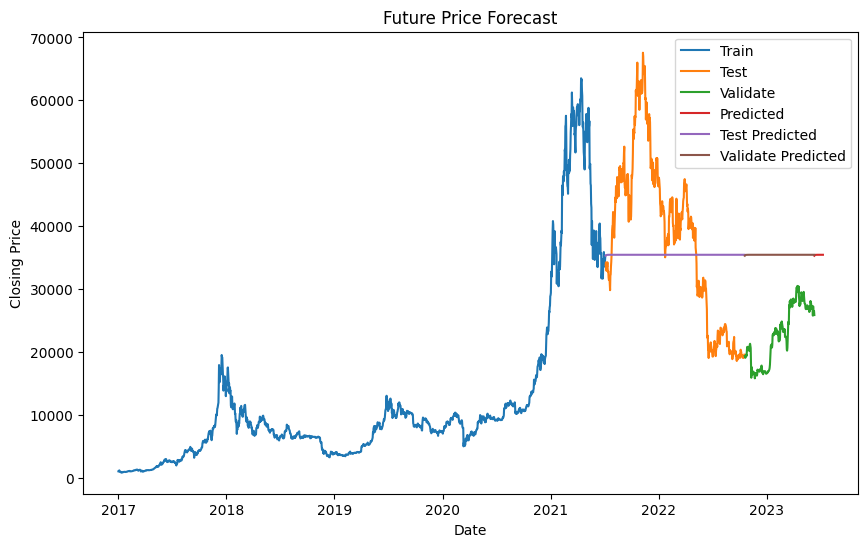

In [46]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/BTC-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [48]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [49]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

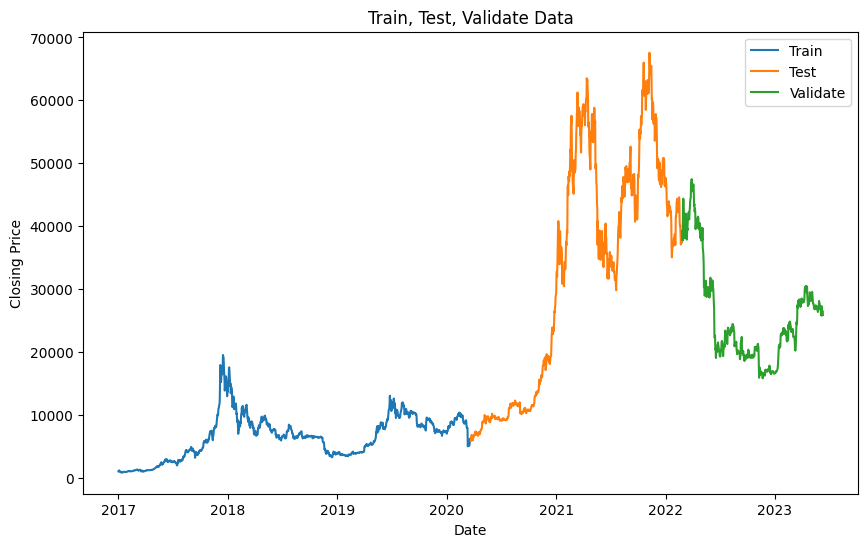

In [50]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [51]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [52]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [53]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

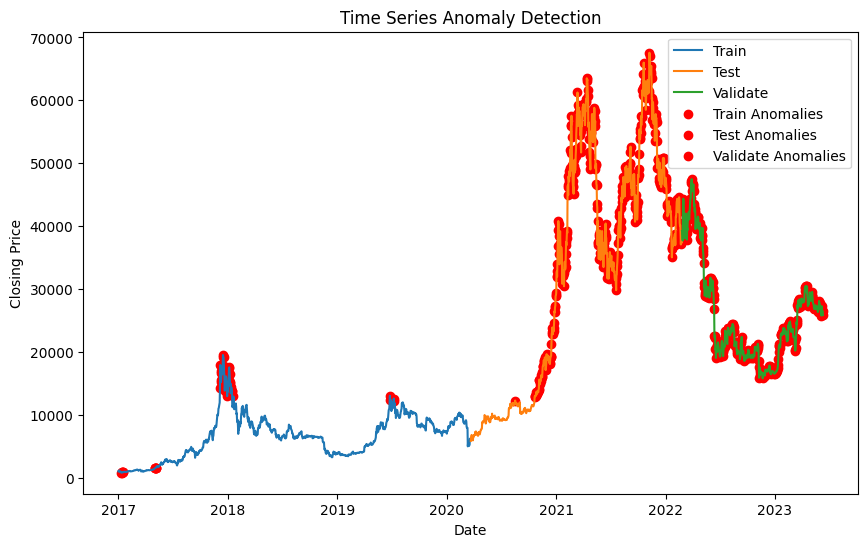

In [54]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

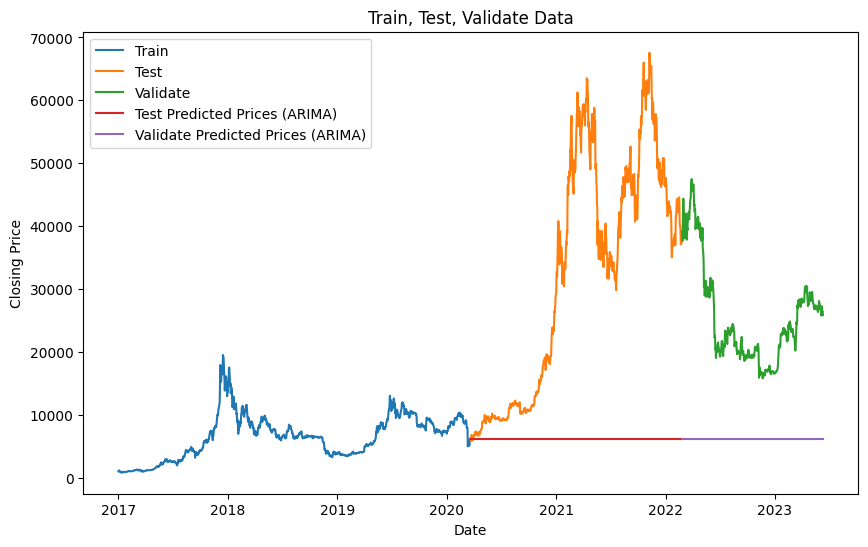

In [55]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [56]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 100.00080920960978
MAE: 25645.749661870403
RMSE: 26807.975361763016
Testing:
MAPE: 100.0000421868808
MAE: 32555.14305502271
RMSE: 37574.16912303363


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17268.278, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17262.325, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17263.655, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17263.643, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17260.489, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17264.330, Time=1.57 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.212 seconds


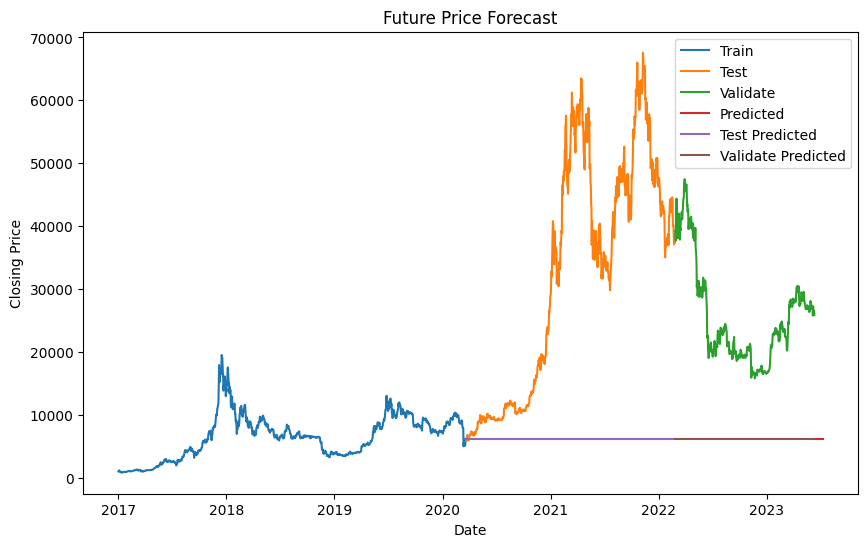

In [57]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

#DOGE-USD

##7:2:1

In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/DOGE-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [59]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [60]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

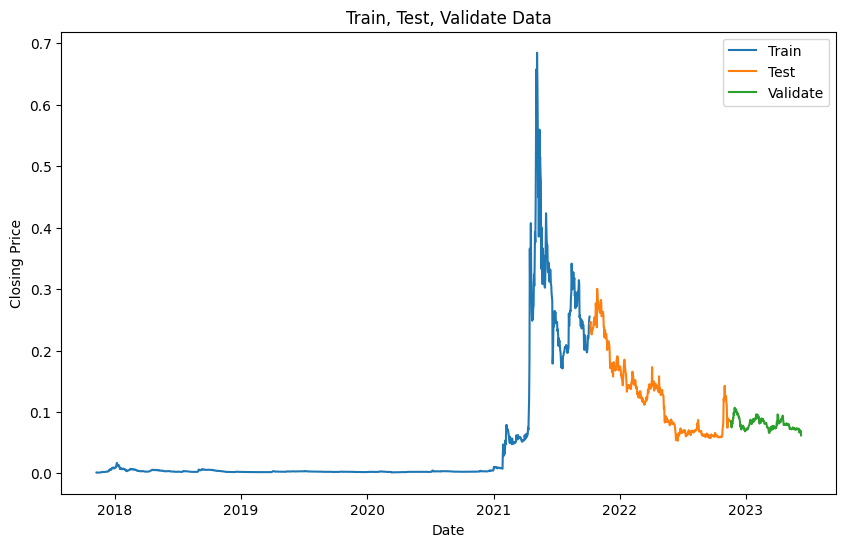

In [61]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [62]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [63]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [64]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

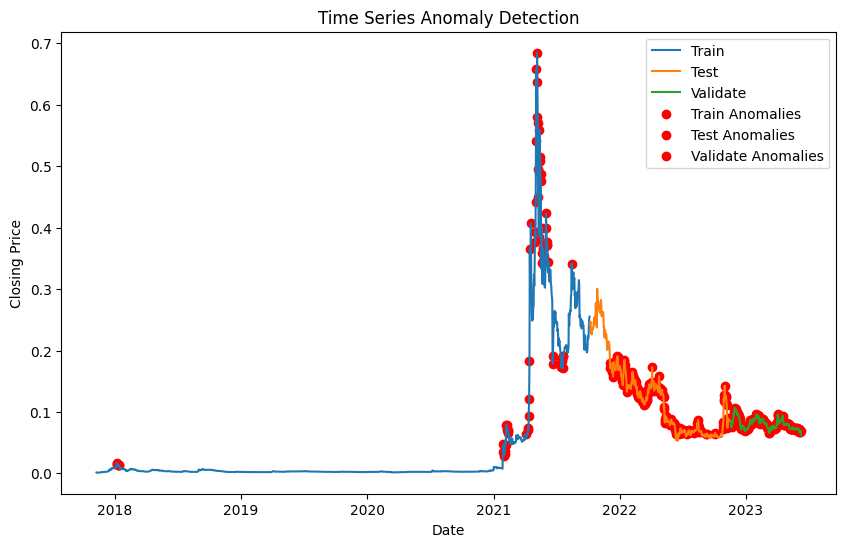

In [65]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

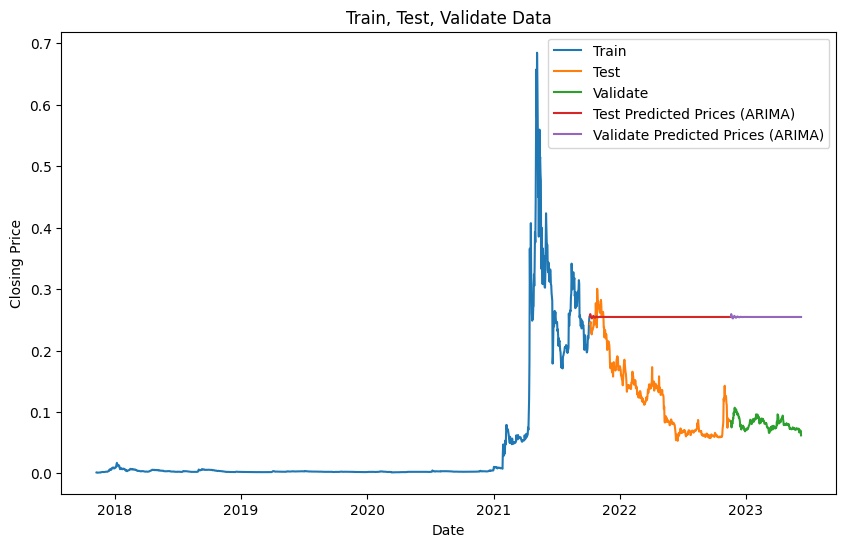

In [66]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [67]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 157.75600809828225
MAE: 0.12801045040778405
RMSE: 0.12976117665921
Testing:
MAPE: 122.23924727119689
MAE: 0.15281535061326423
RMSE: 0.16861010037936847


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8307.530, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8279.768, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8300.783, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8296.926, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8281.512, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8330.444, Time=2.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8318.275, Time=2.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8301.657, Time=1.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8354.706, Time=2.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8356.704, Time=2.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8354.668, Time=2.50 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8362.085, Time=4.63 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-8391.345, Time=4.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8385.451, Time=3.07 sec
 ARIMA(3,1,4)(0,0,0

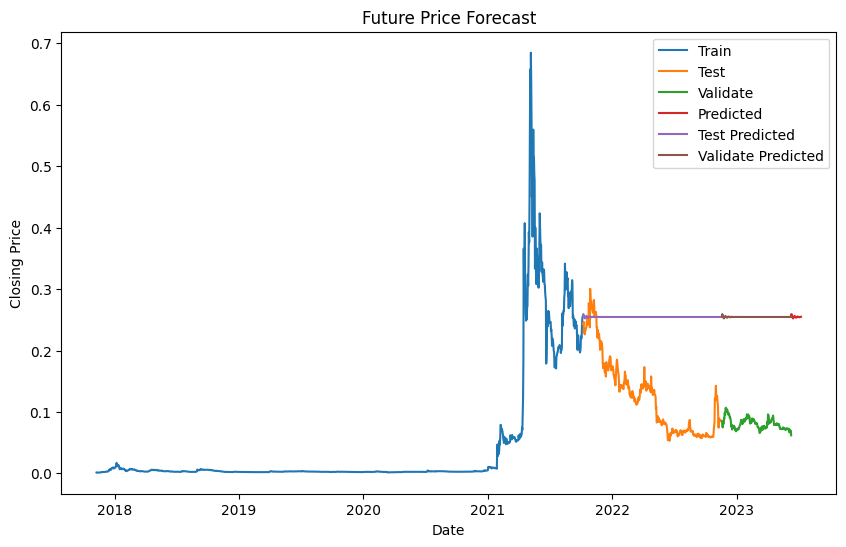

In [68]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [69]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/DOGE-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [70]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [71]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

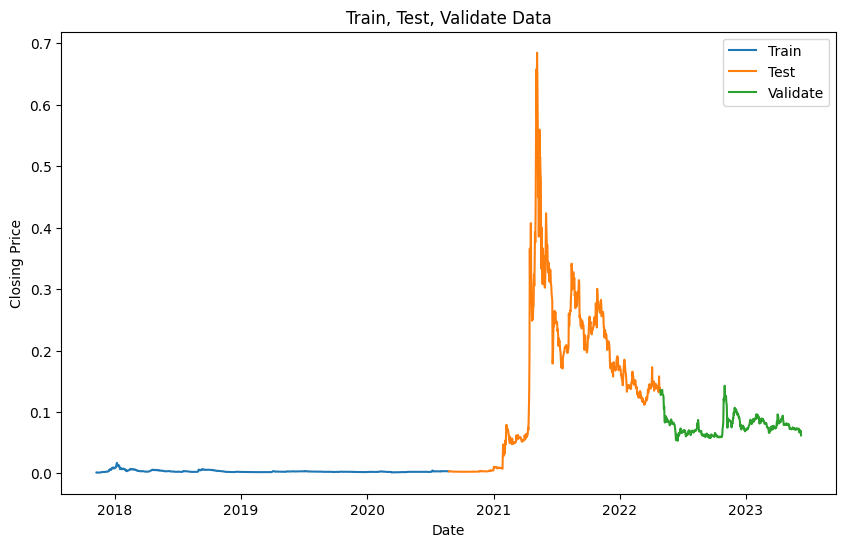

In [72]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [73]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [74]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [75]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

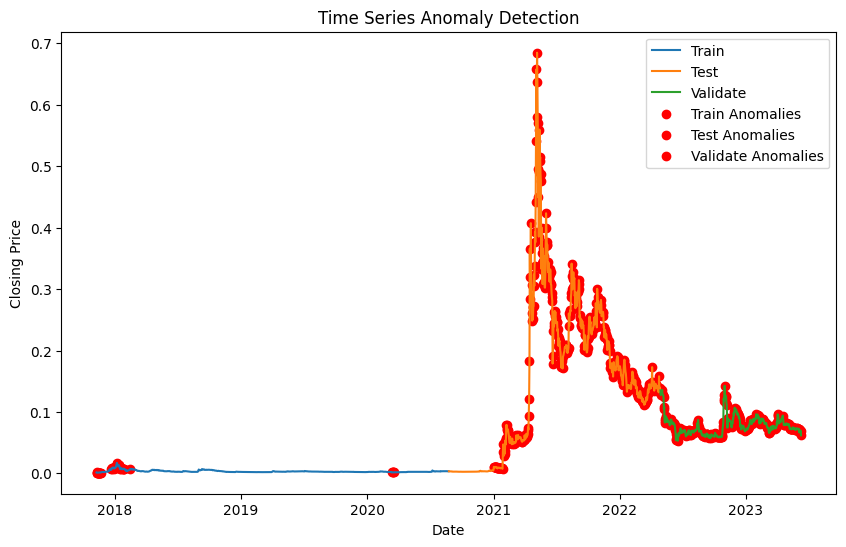

In [76]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


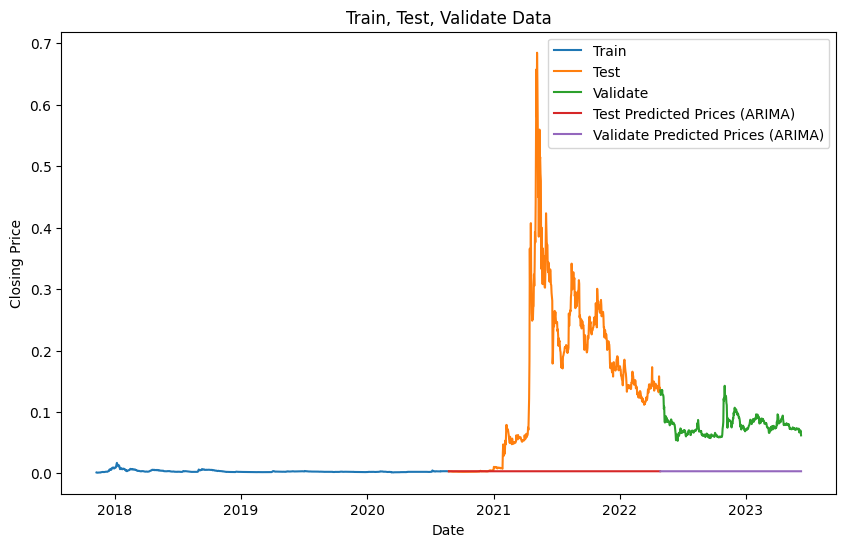

In [77]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [78]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 401.7300998000618
MAE: 0.3055524146712783
RMSE: 0.3059472470510437
Testing:
MAPE: 1516.9336348764177
MAE: 0.35941208943061764
RMSE: 0.38995108806267365


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13497.772, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13492.261, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13509.394, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13509.729, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13494.223, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13507.706, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13507.038, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13510.698, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13505.538, Time=1.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-13506.351, Time=1.71 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13486.110, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13503.011, Time=2.81 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-13512.424, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-13509.011, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13509.677, Time=1.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-13499.882, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-13507.509, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13511.699, Time=0.38 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-13508.330, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13488.072, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-13504.995, Time=0.99 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 16.311 seconds


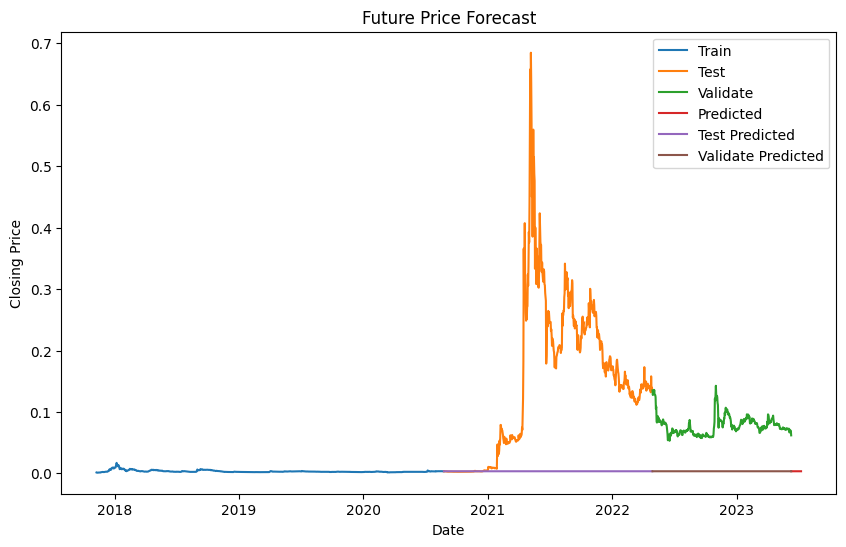

In [79]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

#ETH-USD

##7:2:1

In [80]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/ETH-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [81]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [82]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

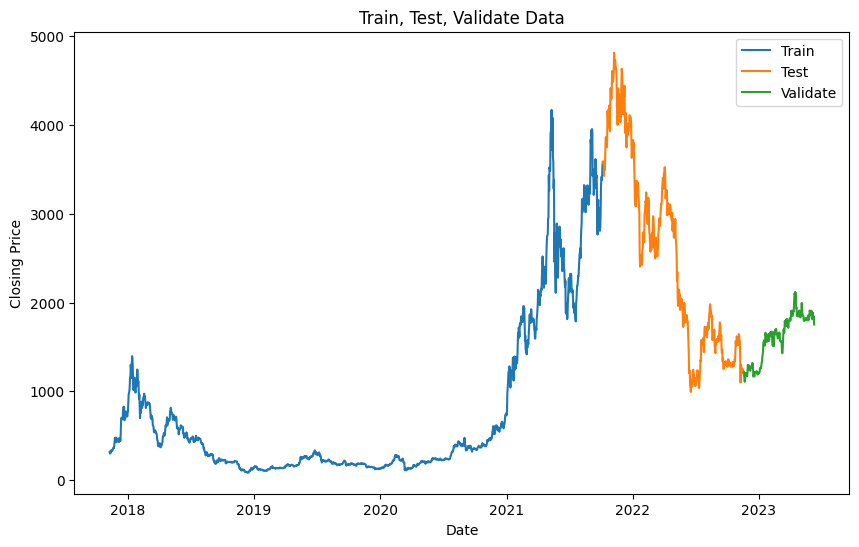

In [83]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [84]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [85]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [86]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

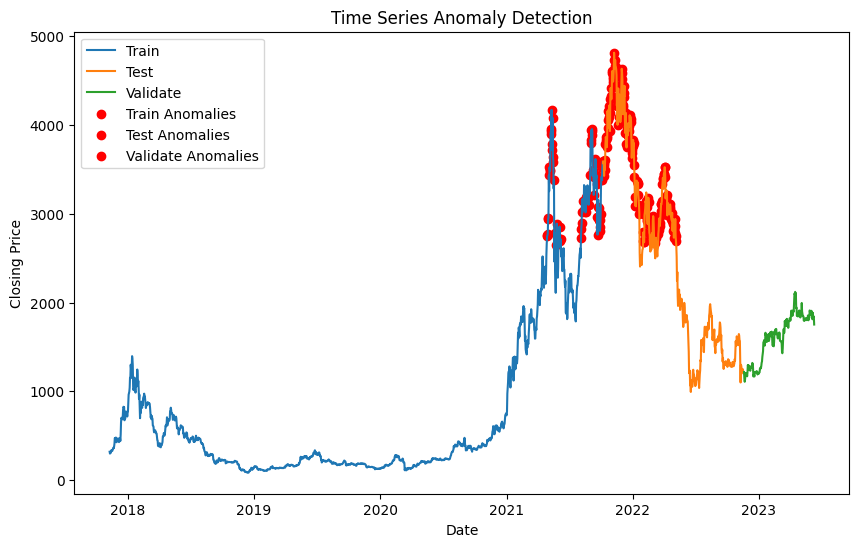

In [87]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

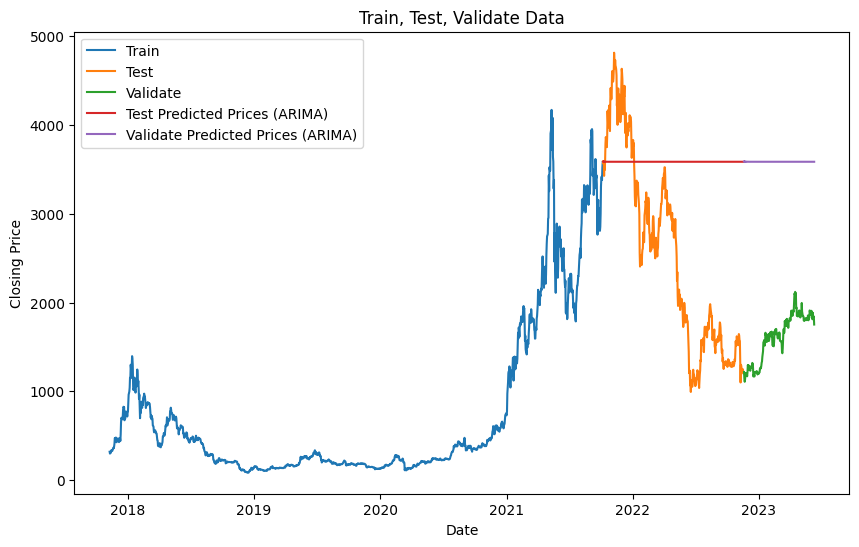

In [88]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [89]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 99.99747731761795
MAE: 1611.5642094671832
RMSE: 1632.6847619713003
Testing:
MAPE: 99.999696600502
MAE: 2522.00046826373
RMSE: 2747.830342025111


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16130.938, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16153.011, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16138.838, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16140.988, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16152.558, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16129.822, Time=1.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16133.538, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16127.976, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16133.226, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16134.019, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16127.720, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16140.873, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16138.745, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16132.684, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0

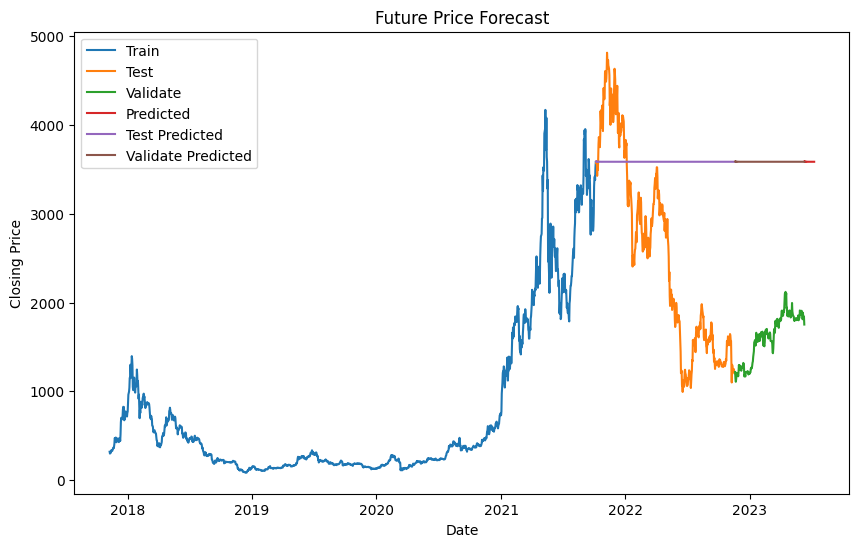

In [90]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()

##5:3:2

In [91]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima

# Đọc dữ liệu từ file CSV
data = pd.read_csv('/content/ETH-USD.csv')
# Chuyển đổi cột 'date' thành đối tượng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Sắp xếp dữ liệu theo ngày
data = data.sort_values('Date')

In [92]:
# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập xác thực
train_size = int(0.5 * len(data))
test_size = int(0.3 * len(data))
validate_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
validate_data = data[train_size+test_size:]

In [93]:
# Lấy cột 'date' và 'close' để vẽ biểu đồ
train_dates = train_data['Date'].values
train_prices = train_data['Close'].values

test_dates = test_data['Date'].values
test_prices = test_data['Close'].values

validate_dates = validate_data['Date'].values
validate_prices = validate_data['Close'].values

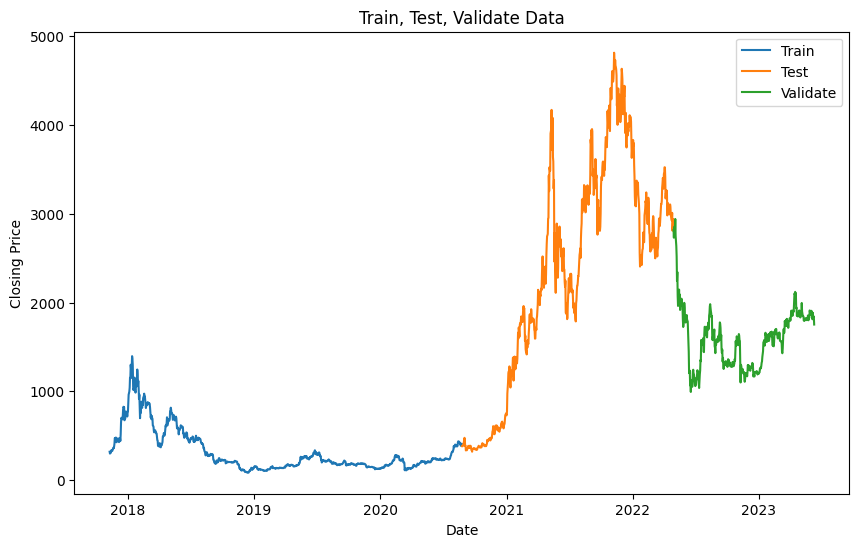

In [94]:
# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [95]:
# Huấn luyện mô hình Isolation Forest để phát hiện bất thường
model = IsolationForest(contamination=0.05)
model.fit(train_prices.reshape(-1, 1))

IsolationForest(contamination=0.05)

In [96]:
# Dự đoán bất thường trên dữ liệu huấn luyện
train_scores = model.decision_function(train_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu kiểm tra
test_scores = model.decision_function(test_prices.reshape(-1, 1))

# Dự đoán bất thường trên dữ liệu xác thực
validate_scores = model.decision_function(validate_prices.reshape(-1, 1))

In [97]:
# Phát hiện bất thường trong dữ liệu huấn luyện
train_anomalies = np.where(model.predict(train_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu kiểm tra
test_anomalies = np.where(model.predict(test_prices.reshape(-1, 1)) == -1)

# Phát hiện bất thường trong dữ liệu xác thực
validate_anomalies = np.where(model.predict(validate_prices.reshape(-1, 1)) == -1)

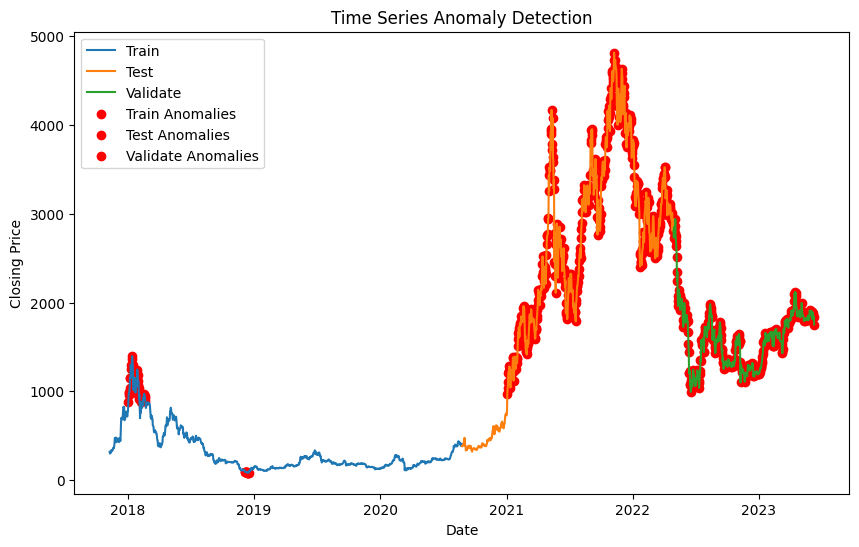

In [98]:
# Vẽ biểu đồ giá đóng cửa và đánh dấu các điểm bất thường
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.scatter(train_dates[train_anomalies], train_prices[train_anomalies], color='red', label='Train Anomalies')
plt.scatter(test_dates[test_anomalies], test_prices[test_anomalies], color='red', label='Test Anomalies')
plt.scatter(validate_dates[validate_anomalies], validate_prices[validate_anomalies], color='red', label='Validate Anomalies')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Time Series Anomaly Detection')
plt.legend()
plt.show()

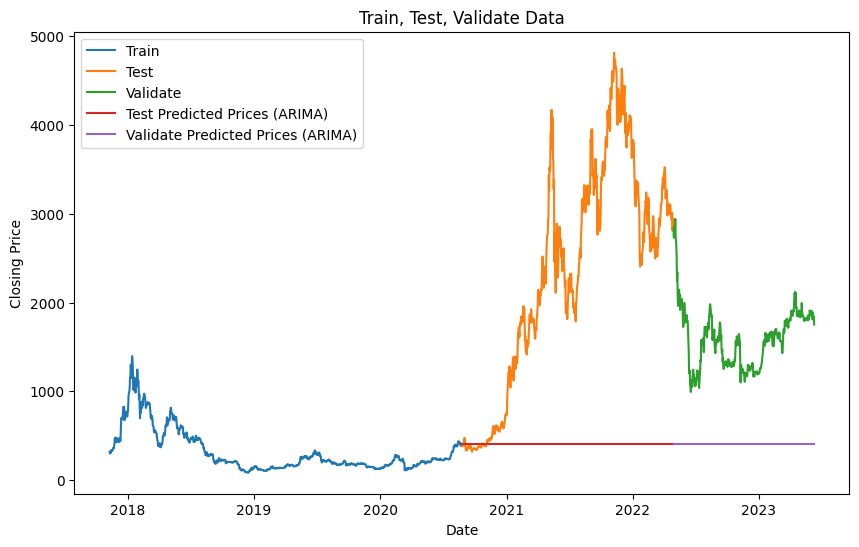

In [99]:
# Dự đoán giá của quá trình testing bằng thuật toán ARIMA
model_arima = auto_arima(train_prices, seasonal=False, trace=False)
test_predicted_prices_arima = model_arima.predict(n_periods=len(test_prices))

# Dự đoán giá của quá trình validation bằng thuật toán ARIMA
validate_predicted_prices_arima = model_arima.predict(n_periods=len(validate_prices))

# Vẽ biểu đồ train, test và validate
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted Prices (ARIMA)')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Train, Test, Validate Data')
plt.legend()
plt.show()

In [100]:
def calculate_metrics(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return mape, mae, rmse

# Calculate metrics for the validation set
validate_mape, validate_mae, validate_rmse = calculate_metrics(validate_prices, validate_scores)

# Calculate metrics for the testing set
test_mape, test_mae, test_rmse = calculate_metrics(test_prices, test_scores)

print("Validation:")
print("MAPE:", validate_mape)
print("MAE:", validate_mae)
print("RMSE:", validate_rmse)

print("Testing:")
print("MAPE:", test_mape)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


Validation:
MAPE: 100.01127363145757
MAE: 1593.3341641373227
RMSE: 1627.4126564317387
Testing:
MAPE: 100.00239605239052
MAE: 2328.6347649091495
RMSE: 2646.90070159835


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9420.722, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9418.650, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9418.884, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9418.879, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9416.662, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9420.878, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.265 seconds


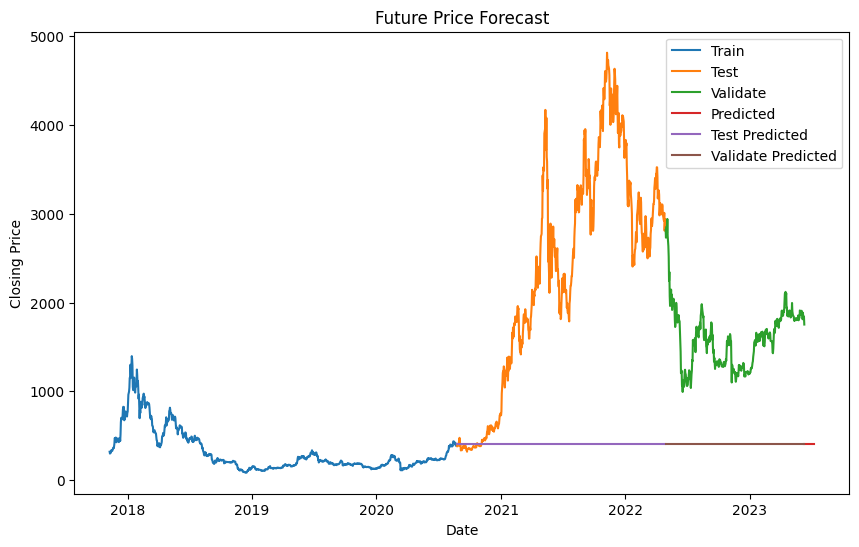

In [101]:
# Huấn luyện mô hình ARIMA trên tập huấn luyện
model = auto_arima(train_prices, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_prices)

# Dự đoán 30 ngày tiếp theo
future_forecast = model.predict(n_periods=30)

# Tạo các ngày dự đoán cho 30 ngày tiếp theo
future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=30)

# Vẽ biểu đồ dự đoán giá trong tương lai
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train_prices, label='Train')
plt.plot(test_dates, test_prices, label='Test')
plt.plot(validate_dates, validate_prices, label='Validate')
plt.plot(future_dates, future_forecast, label='Predicted')
plt.plot(test_dates, test_predicted_prices_arima, label='Test Predicted')
plt.plot(validate_dates, validate_predicted_prices_arima, label='Validate Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Future Price Forecast')
plt.legend()
plt.show()